# Experimenting with xcube

## Imports & Constants

In [2]:
# load credentials from environment variables
%load_ext dotenv
%dotenv

from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers

import time
import geojson
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels.api as sm

request_collector = Observers.request_dumper()
end_dates = ['2018-01-31', '2018-02-28', '2018-03-31']
ic = ['id', 'n_months'] # index columns

## Building the GeoDataFrame

In [113]:
# Read GeoJSON
gdf = gpd.read_file('../geodata/municipalities_sample_bbox.geojson')

# Store geometry representations
gdf['bbox'] = gdf.bounds.apply(tuple, axis=1)
gdf['wkt'] = gdf.apply(lambda f: f.geometry.wkt, axis=1)
gdf['geojson'] = gdf.apply(lambda f: f.geometry.__geo_interface__, axis=1)

# Calculate areas in m²
area_25832 = gdf.cx[:12.0,:].to_crs('EPSG:25832').area # ETRS89 / UTM Zone 32N for Vbg and Tyrol
area_25833 = gdf.cx[12.0:,:].to_crs('EPSG:25833').area # ETRS89 / UTM Zone 33N for rest of Austria
gdf['area'] = pd.concat([area_25832,area_25833])

## Functions

In [219]:
def write_cube(feature, time_range, n_months):
    '''
    This will write a zarr file using the specified parameters.
    
    # Input
    
    tuple(*attributes) feature
    list[date_string start, date_string end] time_range
    
    
    # Example: 
    
    write_cube(
        Pandas(
            Index=0,
            id='10604',
            name='Loipersbach im Burgenland',
            bbox=(16.446445736463346, 47.680841561177864, 16.49776618971013, 47.72587417451863),
            wkt='MULTIPOLYGON (((16.47614442528707 47.71419149821737,...)))
        ),
        ['2018-01-01', '2018-01-31']
    )
    '''
    
    bands = ["B04", "B03", "B02", "B08", "B05", "B06", "B07", "B8A", "B11", "B12"]
    config = CubeConfig(
        dataset_name="S2L2A",
        band_names=bands,
        geometry=feature.bbox,
        #tile_size=[1024, 12],
        crs='http://www.opengis.net/def/crs/EPSG/0/4326',
        spatial_res=0.000134,
        time_range=time_range,
        time_period='2W'
    )
    open_cube(config, observer=request_collector).to_zarr(f"{feature.Index}_{n_months}_{feature.name}_{'_'.join(time_range)}_{time.time()}.zarr")

## xcube in action 🔢

In [225]:
%%time
!rm -r *.zarr
times = []

for i in range(len(end_dates)):
    n_months = i+1
    for feat in gdf.drop('geometry', axis=1).itertuples():
        #tr = %timeit -n 1 -r 3 -o write_cube(feat, ['2018-01-01', end_dates[i]], n_months) # TimeitResult
        tr = %timeit -n 1 -r 3 -o write_cube(feat, ['2018-01-01', '2018-09-30'], 9) # TimeitResult
        times.append({ic[0]: feat.Index, ic[1]: n_months, **vars(tr), 'mean': tr.average, 'stdev': tr.stdev})
        break
    break

Received chunk (1, 0, 0) for band B8A: took 317.00 ms
Received chunk (0, 0, 0) for band B8A: took 374.53 ms
Received chunk (3, 0, 0) for band B8A: took 359.91 ms
Received chunk (4, 0, 0) for band B8A: took 381.96 ms
Received chunk (2, 0, 0) for band B8A: took 1058.73 ms
Received chunk (5, 0, 0) for band B8A: took 298.19 ms
Received chunk (6, 0, 0) for band B8A: took 439.80 ms
Received chunk (7, 0, 0) for band B8A: took 424.63 ms
Received chunk (8, 0, 0) for band B8A: took 351.28 ms
Received chunk (9, 0, 0) for band B8A: took 390.01 ms
Received chunk (10, 0, 0) for band B8A: took 355.44 ms
Received chunk (11, 0, 0) for band B8A: took 294.02 ms
Received chunk (13, 0, 0) for band B8A: took 365.82 ms
Received chunk (12, 0, 0) for band B8A: took 714.68 ms
Received chunk (14, 0, 0) for band B8A: took 396.89 ms
Received chunk (15, 0, 0) for band B8A: took 388.16 ms
Received chunk (16, 0, 0) for band B8A: took 376.67 ms
Received chunk (17, 0, 0) for band B8A: took 393.50 ms
Received chunk (18,

## Munging Results

In [222]:
# Build disk usage dataframe
disk_usage = !du *.zarr -s
dudf = pd.DataFrame([du.split('\t') for du in disk_usage], columns=["KB", "filename"])
dudf['KB'] = pd.to_numeric(dudf['KB'])
dudf[ic[0]], dudf[ic[1]] = list(zip(*dudf['filename'].apply(lambda fn: fn.split('_')[:2])))

# Make sure that orginal index is used
dudf = dudf.drop_duplicates(subset=ic)
dudf[ic] = dudf[ic].apply(pd.to_numeric)
dudf = dudf.set_index(ic)

#assert len(dudf) == len(gdf)*len(end_dates), 'DataFrame sizes do not match'
dudf

,,KB,filename
id,n_months,,
0,1,8748,0_1_Loipersbach im Burgenland_2018-01-01_2018-...


In [229]:
# Build Time Dataframe
tdf = pd.DataFrame(times).set_index(ic)
#assert len(tdf) == len(gdf)*len(end_dates), 'DataFrame sizes do not match'
tdf.loc[(slice(None),1),:]

,,_precision,all_runs,best,compile_time,loops,mean,repeat,stdev,timings,worst
id,n_months,,,,,,,,,,
0,1,3,"[49.28566919686273, 45.681024740915745, 43.459...",43.459077,0.000089,1,46.141924,3,2.400918,"[49.28566919686273, 45.681024740915745, 43.459...",49.285669


## Predictions

In [233]:
preddf

,,KB,area
id,n_months,,
0,1,8748,1.927560e+07


In [235]:
preddf = pd.merge(dudf['KB'], gdf['area'],how="left", left_on=ic[0], right_index=True)
#preddf = preddf.loc[(slice(None),), :]

Y = np.asarray(preddf['KB'])
X = sm.add_constant(np.asarray(preddf['area']))
model = sm.OLS(Y,X).fit()
model.predict(X)

array([8748.])

## Plots

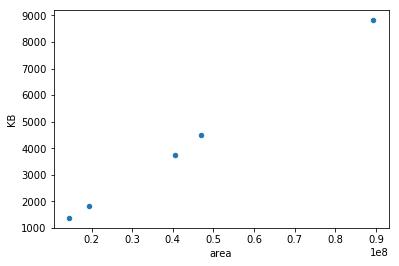

In [217]:
preddf.plot(x='area', y='KB', kind='scatter')

In [278]:
factor=float(17269/preddf['area'][0]*10**6)
print(f'{(8748*factor)/1000000:.2f} GB')
print(f'{48.5*factor/60/60:.2f}h')

7.84 GB
12.07h


895.8994636115259